In [1]:
## Planned datasets - Image (different image sizes/ Different number of classes), 
##                    Classification (Different feature size / Different number of classes)

## Planned models - FC/Dropout, CNN(LeNet)/Resnet/Inception (Maybe include attention)

## Predict running time based on Layers/No of params/FLOPs
## Calculate total number of computations (based on dataset/model size)
## Calculate approx cost on GCP (or any cloud platform)

import tensorflow as tf

In [2]:
def create_fc(config):
    config['hidden_layers'] = len(config['layers'])
    input = tf.keras.layers.Input(shape=config['input_shape'])
    if config['input_dropout'] is not None:
        x = tf.keras.layers.Dropout(config['input_dropout'])(input)
    else:
        x = input
    for i in range(config['hidden_layers']):
        dim = config['layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)
        if config['dropout'] is not None:
            x = tf.keras.layers.Dropout(config['dropout'])(x)
    x = tf.keras.layers.Dense(config['output_shape'],activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=x)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                                metrics=['accuracy'])
    return model

2021-12-01 07:12:22.943576: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-01 07:12:28.051587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38464 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


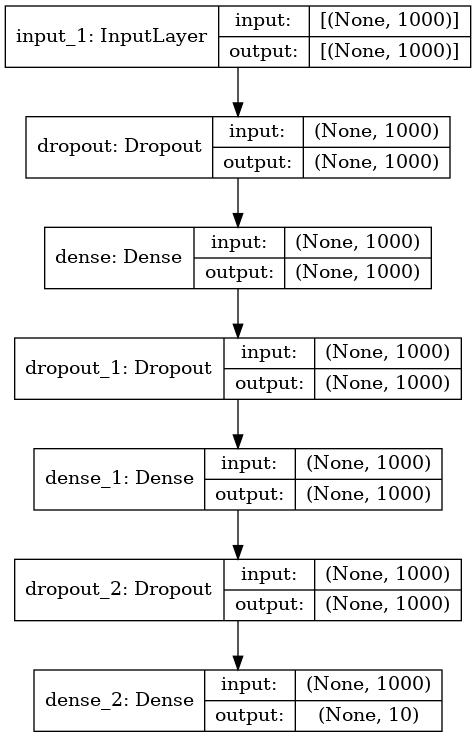

In [3]:
fc_config = dict()
fc_config['input_shape'] = 1000
fc_config['output_shape'] = 10
fc_config['input_dropout'] = 0.2
fc_config['dropout'] = 0.5
fc_config['hidden_layers'] = 2
fc_config['layers'] = [1000,1000]
# Output activation = always sigmoid
# All hidden layers have same dropout
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

fc_model = create_fc(fc_config)

tf.keras.utils.plot_model(fc_model,show_shapes=True)

In [4]:
def vgg_block(x, filters, layers):
    for _ in range(layers):
        x = tf.keras.layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2))(x)
    return x

def create_vgg(config):
    config['num_layers'] = len(config['vgg_layers'])
    input = tf.keras.layers.Input(shape=config['input_shape'])
    x = input
    for i in range(config['num_layers']):
        block_size = config['vgg_layers'][i]
        filter_num = config['filters'][i]
        act = 'relu'
        x = vgg_block(x,filter_num,block_size)
    x = tf.keras.layers.Flatten()(x)
    config['num_hidden_layers'] = len(config['hidden_layers'])
    for i in range(config['num_hidden_layers']):
        dim = config['hidden_layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)

    x = tf.keras.layers.Dense(config['output_shape'],activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=x)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                                metrics=['accuracy'])
    return model

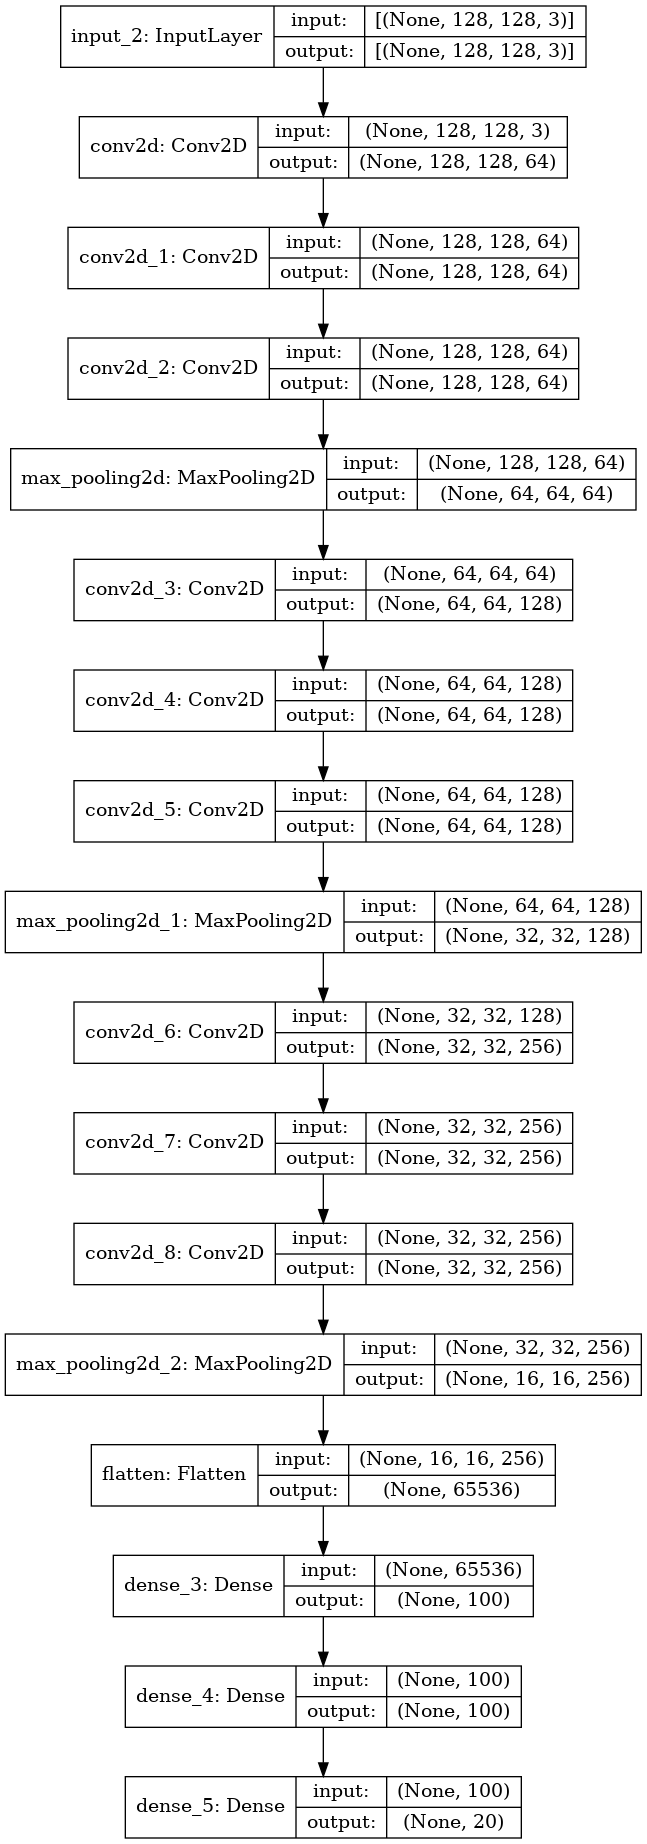

In [5]:
vgg_config = dict()
vgg_config['input_shape'] = (128,128,3)
vgg_config['vgg_layers'] = [3,3,3]
vgg_config['filters'] = [64,128,256]
vgg_config['hidden_layers'] = [100,100]
vgg_config['output_shape'] = 20
# Output activation = always sigmoid
# All convolution layers have 3x3 kernel and same padding
# All pooling layers (end of VGG block) reduce image size by half
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

vgg_model = create_vgg(vgg_config)

tf.keras.utils.plot_model(vgg_model,show_shapes=True)

In [6]:
def inception_block(x, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = tf.keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    # 3x3 conv
    conv3 = tf.keras.layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(x)
    conv3 = tf.keras.layers.Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = tf.keras.layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(x)
    conv5 = tf.keras.layers.Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = tf.keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool = tf.keras.layers.Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = tf.keras.layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

def create_inception(config):
    config['num_layers'] = len(config['inception_layers'])
    input = tf.keras.layers.Input(shape=config['input_shape'])
    x = tf.keras.layers.Conv2D(64, (7,7), padding='valid', activation='relu', strides=(2,2))(input)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = tf.keras.layers.Conv2D(128, (1,1), padding='same', activation='relu', strides=(1,1))(x)
    x = tf.keras.layers.Conv2D(192, (3,3), padding='same', activation='relu', strides=(1,1))(x)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    for i in range(config['num_layers']):
        for j in range(config['inception_layers'][i]):
            x = inception_block(x,config['f1'][i][j],config['f2_in'][i][j],config['f2_out'][i][j],
                                                    config['f3_in'][i][j],config['f3_out'][i][j],config['f4_out'][i][j])
        x = tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    config['num_hidden_layers'] = len(config['hidden_layers'])
    for i in range(config['num_hidden_layers']):
        dim = config['hidden_layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)

    x = tf.keras.layers.Dense(config['output_shape'],activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=x)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                                optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                                metrics=['accuracy'])
    return model

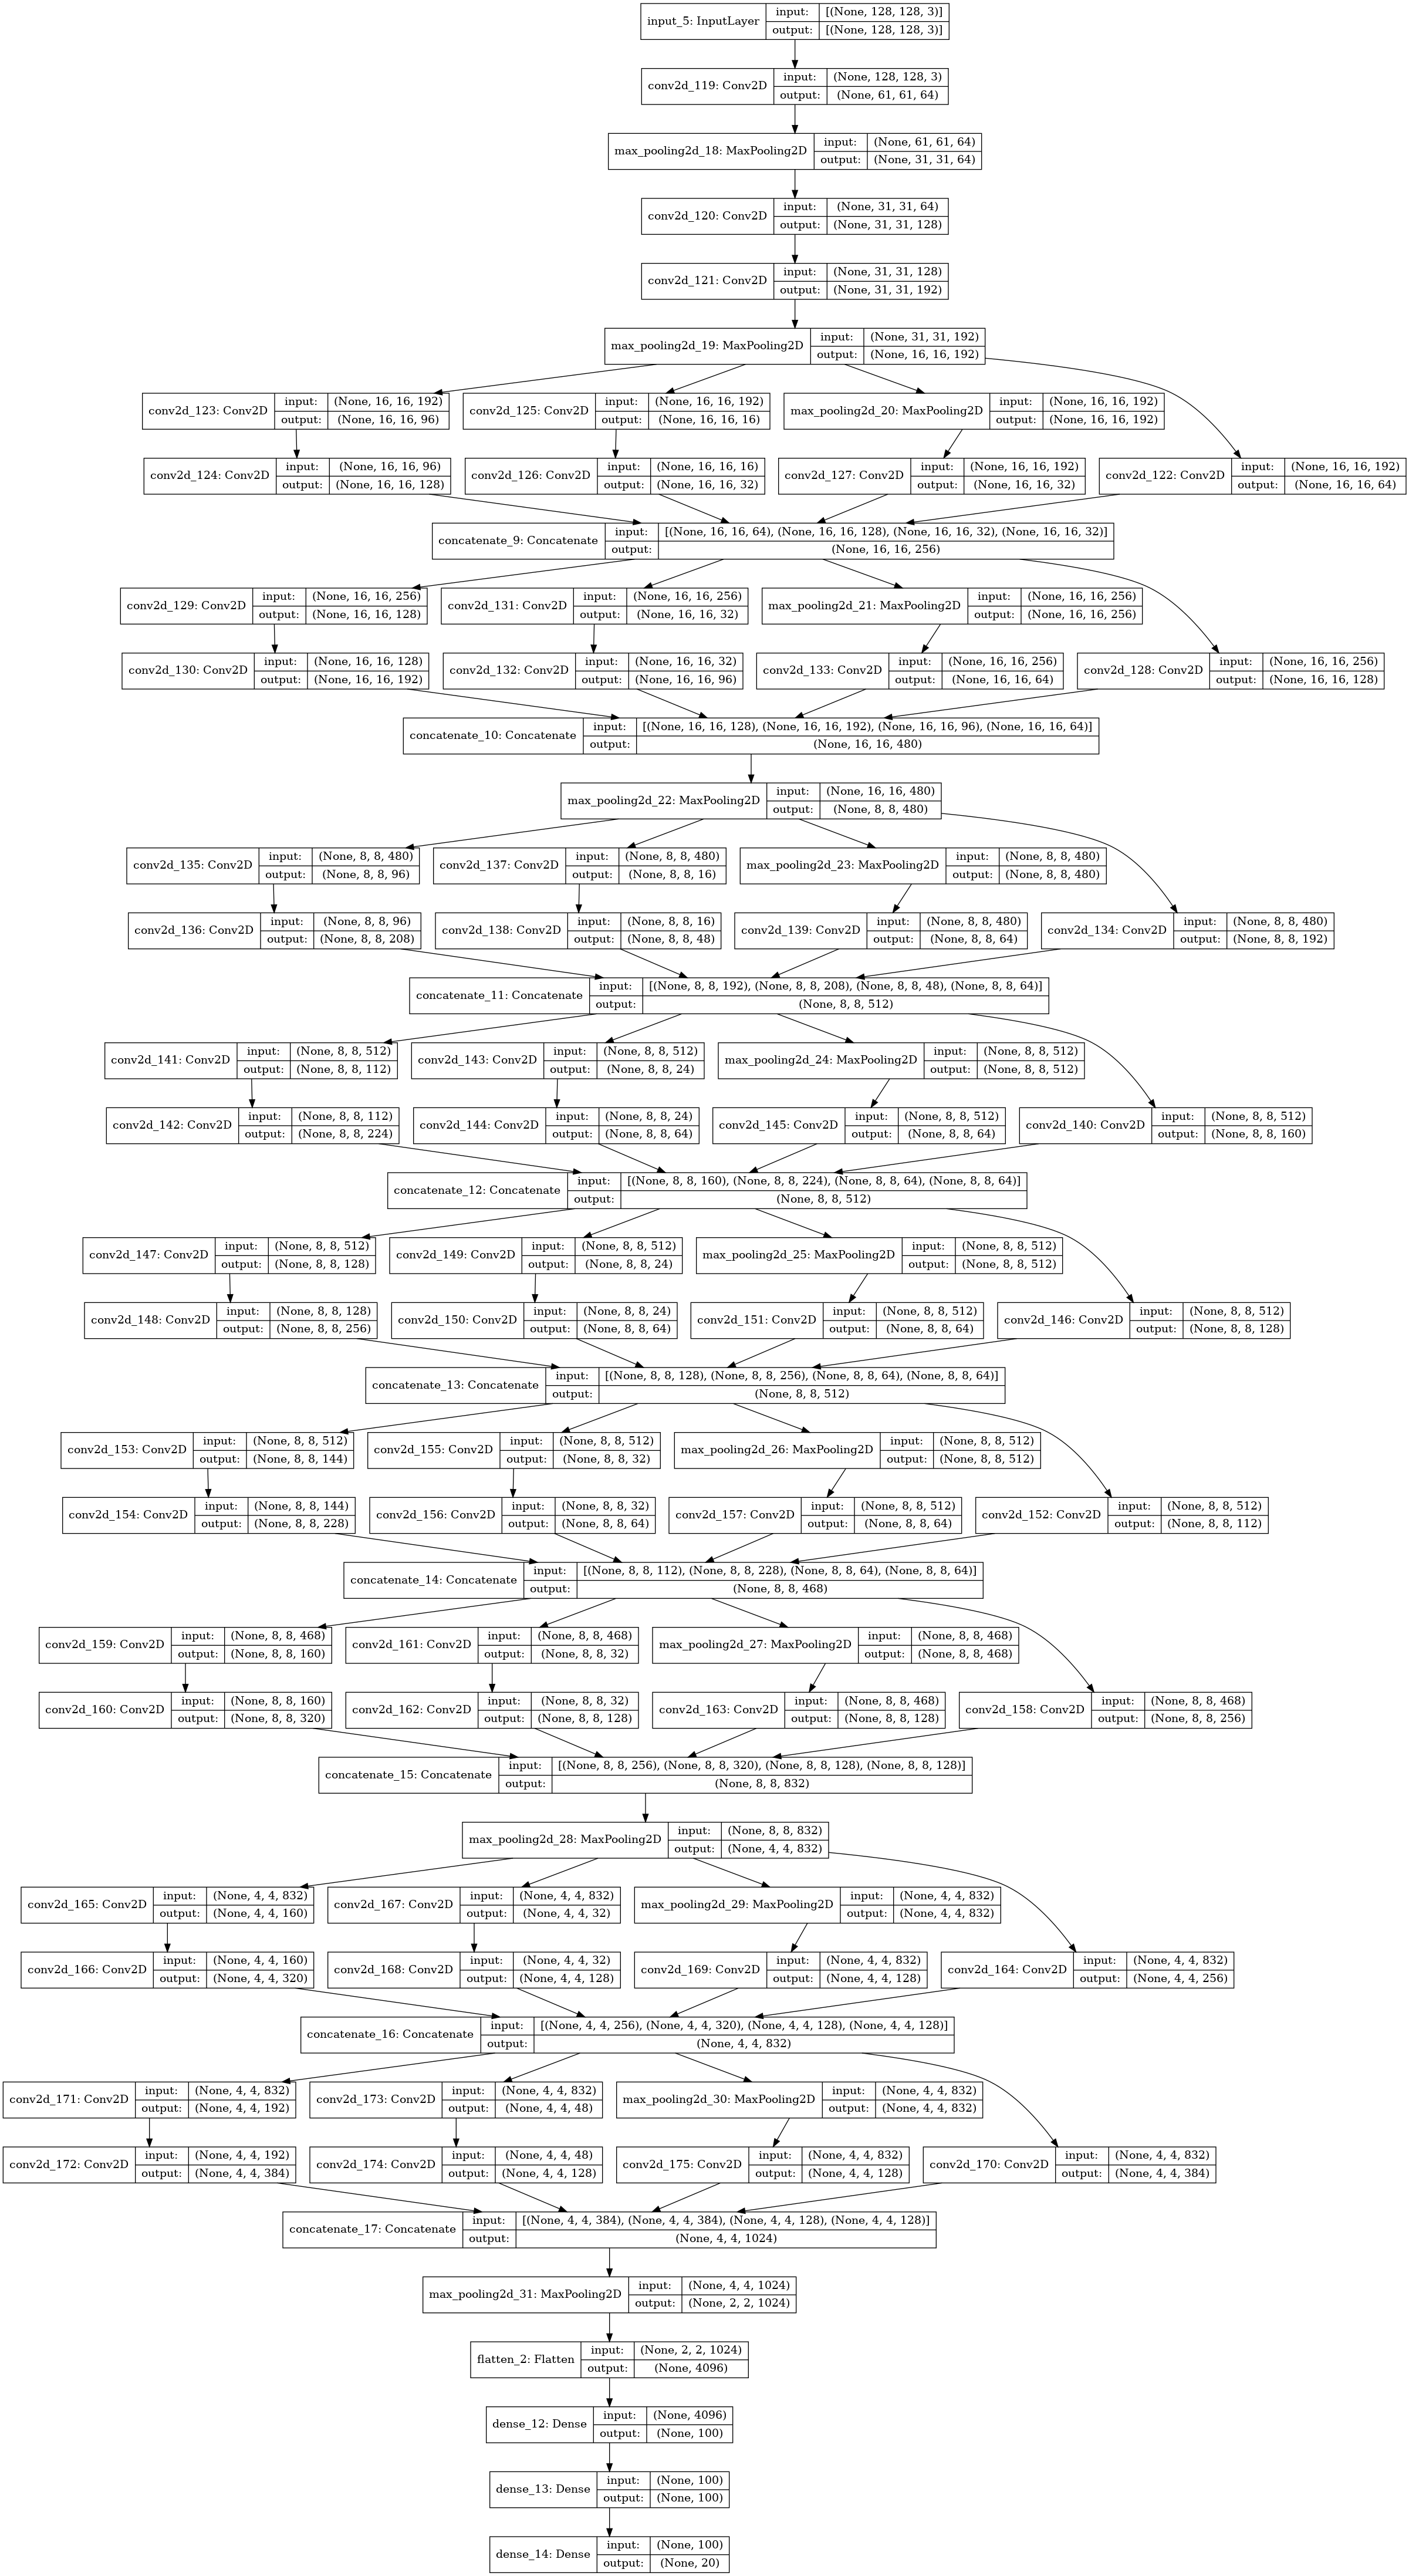

In [12]:
inception_config = dict()
inception_config['input_shape'] = (128,128,3)
inception_config['inception_layers'] = [2,5,2]
inception_config['f1'] = [[64,128],[192,160,128,112,256],[256,384]]
inception_config['f2_in'] = [[96,128],[96,112,128,144,160],[160,192]]
inception_config['f2_out'] = [[128,192],[208,224,256,228,320],[320,384]]
inception_config['f3_in'] = [[16,32],[16,24,24,32,32],[32,48]]
inception_config['f3_out'] = [[32,96],[48,64,64,64,128],[128,128]]
inception_config['f4_out'] = [[32,64],[64,64,64,64,128],[128,128]]
inception_config['hidden_layers'] = [100,100]
inception_config['output_shape'] = 20
# Output activation = always sigmoid
# All convolution layers have 3x3 kernel and same padding
# All pooling layers (end of VGG block) reduce image size by half
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

inception_model = create_inception(inception_config)

tf.keras.utils.plot_model(inception_model,show_shapes=True)

In [13]:
def conv_relu(x, filters, kernel_size, strides=1):
        
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding = 'same')(x)
        x = tf.keras.layers.ReLU()(x)
        
        return x

def identity_block(tensor, filters):
        
        x = conv_relu(tensor, filters=filters, kernel_size=1, strides=1)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        x = tf.keras.layers.Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
        
        x = tf.keras.layers.Add()([tensor,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def identity_block_small(tensor, filters):
        
        x = conv_relu(tensor, filters=filters, kernel_size=3, strides=1)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        
        x = tf.keras.layers.Add()([tensor,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def projection_block(tensor, filters, strides):
        
        x = conv_relu(tensor, filters=filters, kernel_size=1, strides=strides)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        x = tf.keras.layers.Conv2D(filters=4*filters, kernel_size=1, strides=1)(x)
        
        shortcut = tf.keras.layers.Conv2D(filters=4*filters, kernel_size=1, strides=strides)(tensor)
        
        x = tf.keras.layers.Add()([shortcut,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def projection_block_small(tensor, filters, strides):
        
        x = conv_relu(tensor, filters=filters, kernel_size=3, strides=strides)
        x = conv_relu(x, filters=filters, kernel_size=3, strides=1)
        
        shortcut = tf.keras.layers.Conv2D(filters=filters, kernel_size=1, strides=strides)(tensor)
        
        x = tf.keras.layers.Add()([shortcut,x])
        x = tf.keras.layers.ReLU()(x)
        
        return x

def resnet_block(x, filters, reps, strides):
        
        x = projection_block(x, filters, strides)
        for _ in range(reps-1):
                x = identity_block(x,filters)
                
        return x

def resnet_block_small(x, filters, reps, strides):
        
        x = projection_block_small(x, filters, strides)
        for _ in range(reps):
                x = identity_block_small(x,filters)
                
        return x

def resnet(config):

    input = tf.keras.layers.Input(shape=config['input_shape'])

    x = conv_relu(input, filters=64, kernel_size=7, strides=2)
    x = tf.keras.layers.MaxPool2D(pool_size = 3, strides =2)(x)
    if config['small']==False:
            x = resnet_block(x, filters=64, reps=config['resnet_layers'][0], strides=1)
            x = resnet_block(x, filters=128, reps=config['resnet_layers'][1], strides=2)
            x = resnet_block(x, filters=256, reps=config['resnet_layers'][2], strides=2)
            x = resnet_block(x, filters=512, reps=config['resnet_layers'][3], strides=2)
    else:
            x = resnet_block_small(x, filters=64, reps=config['resnet_layers'][0], strides=1)
            x = resnet_block_small(x, filters=128, reps=config['resnet_layers'][1], strides=2)
            x = resnet_block_small(x, filters=256, reps=config['resnet_layers'][2], strides=2)
            x = resnet_block_small(x, filters=512, reps=config['resnet_layers'][3], strides=2)
    x = tf.keras.layers.GlobalAvgPool2D()(x)

    config['num_hidden_layers'] = len(config['hidden_layers'])
    for i in range(config['num_hidden_layers']):
        dim = config['hidden_layers'][i]
        act = 'relu'
        x = tf.keras.layers.Dense(dim,activation=act)(x)

    output = tf.keras.layers.Dense(config['output_shape'], activation ='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                            metrics=['accuracy'])
    return model

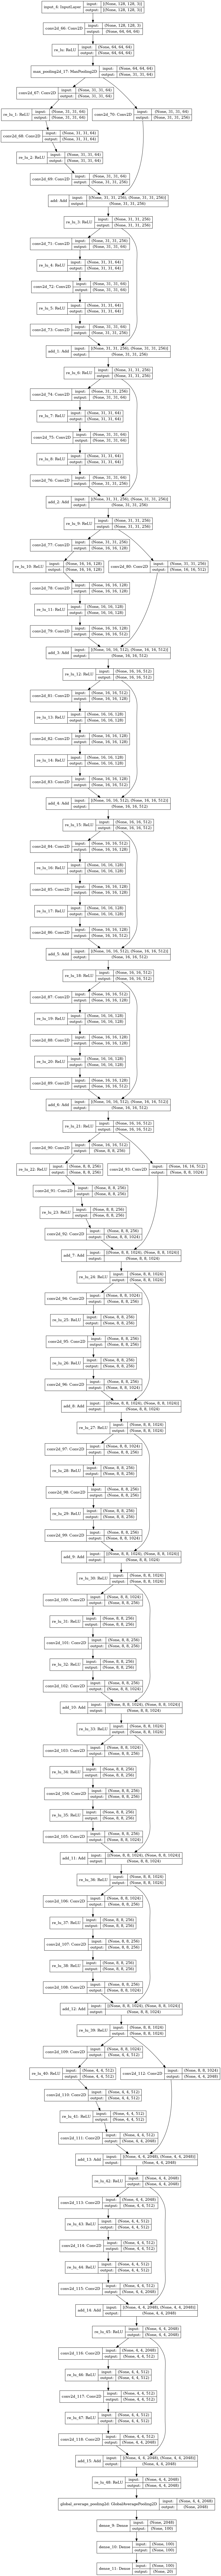

In [9]:
resnet_config = dict()
resnet_config['input_shape'] = (128,128,3)
resnet_config['small'] = False
resnet_config['resnet_layers'] = [3,4,6,3]
resnet_config['hidden_layers'] = [100,100]
resnet_config['output_shape'] = 20
resnet_model = resnet(resnet_config)
# Output activation = always sigmoid
# All resnet blocks have same structure. Can only specify number of repeating blocks (4 list)
# Can also specify if small architecture or not (refer paper)
# All hidden layers activated with ReLU
# Optimizer is always sgd with lr = 0.01 and momentum=0.9

tf.keras.utils.plot_model(resnet_model,show_shapes=True)

In [10]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model, batch_size=None):
    if batch_size is None:
        batch_size = 1

    real_model = tf.function(model).get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                            run_meta=run_meta, cmd='op', options=opts)
    return flops

In [14]:
fc_flops = get_flops(fc_model, batch_size=1)
vgg_flops = get_flops(vgg_model, batch_size=1)
inception_flops = get_flops(inception_model, batch_size=1)
resnet_flops = get_flops(resnet_model, batch_size=1)

2021-12-01 07:14:29.514070: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-12-01 07:14:29.514621: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-12-01 07:14:29.542123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38464 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
2021-12-01 07:14:29.586063: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.095ms.
  function_optimizer: function_optimizer did nothing. time = 0.003ms.




=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

2021-12-01 07:14:31.310941: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-12-01 07:14:31.325996: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-12-01 07:14:31.352694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38464 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
2021-12-01 07:14:31.360778: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.018ms.
  function_optimizer: function_optimizer did nothing. time = 0.002ms.




=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

2021-12-01 07:14:39.206026: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-12-01 07:14:39.206393: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-12-01 07:14:39.236713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38464 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
2021-12-01 07:14:39.268316: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.062ms.
  function_optimizer: function_optimizer did nothing. time = 0.003ms.




=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

2021-12-01 07:14:48.153358: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-12-01 07:14:48.181821: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-12-01 07:14:48.189488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38464 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
2021-12-01 07:14:48.241475: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.026ms.
  function_optimizer: function_optimizer did nothing. time = 0.002ms.




=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

In [16]:
fc_flops.total_float_ops

4022060

In [22]:
fc_flops.children[0].name

'MatMul'

In [29]:
x = fc_flops.children
while(len(x) > 0):
    print(x[0].name)
    x = x[0].children

MatMul
BiasAdd
Softmax


In [30]:
x = vgg_flops.children
while(len(x) > 0):
    print(x[0].name)
    x = x[0].children

Conv2D
MatMul
BiasAdd
MaxPool
Softmax


In [31]:
x = resnet_flops.children
while(len(x) > 0):
    print(x[0].name)
    x = x[0].children

Conv2D
BiasAdd
MaxPool
MatMul
Mean
Softmax


In [32]:
x = inception_flops.children
while(len(x) > 0):
    print(x[0].name)
    x = x[0].children

Conv2D
MaxPool
BiasAdd
MatMul
Softmax


In [37]:
trainable_count = int(np.sum([tf.count_params(p) for p in (fc_model.trainable_weights)]))

non_trainable_count = int(np.sum([tf.count_params(p) for p in (fc_model.non_trainable_weights)]))

AttributeError: module 'tensorflow' has no attribute 'count_params'

In [34]:
import numpy as np

In [47]:
np.sum([np.product([xi for xi in x.get_shape()]) for x in model.trainable_variables])

6397744

In [48]:
np.sum([np.product([xi for xi in x.get_shape()]) for x in model.non_trainable_variables])

0.0

In [49]:
np.sum([np.product([xi for xi in x.get_shape()]) for x in model.trainable_weights])

6397744

In [51]:
np.sum([np.product([xi for xi in x.get_shape()]) for x in model.non_trainable_weights])

0.0

In [54]:
def get_weights(model):
    print(np.sum([np.product([xi for xi in x.get_shape()]) for x in model.weights]))

In [55]:
get_weights(fc_model)
get_weights(resnet_model)
get_weights(inception_model)
get_weights(vgg_model)

2012010
23698492
6397744
8485820


In [56]:
l = resnet_model.layers[0]

In [60]:
for l in resnet_model.layers:
    w = np.sum([np.product([xi for xi in x.get_shape()]) for x in l.weights])
    if w > 0:
        print(l.name)

conv2d_66
conv2d_67
conv2d_68
conv2d_70
conv2d_69
conv2d_71
conv2d_72
conv2d_73
conv2d_74
conv2d_75
conv2d_76
conv2d_77
conv2d_78
conv2d_80
conv2d_79
conv2d_81
conv2d_82
conv2d_83
conv2d_84
conv2d_85
conv2d_86
conv2d_87
conv2d_88
conv2d_89
conv2d_90
conv2d_91
conv2d_93
conv2d_92
conv2d_94
conv2d_95
conv2d_96
conv2d_97
conv2d_98
conv2d_99
conv2d_100
conv2d_101
conv2d_102
conv2d_103
conv2d_104
conv2d_105
conv2d_106
conv2d_107
conv2d_108
conv2d_109
conv2d_110
conv2d_112
conv2d_111
conv2d_113
conv2d_114
conv2d_115
conv2d_116
conv2d_117
conv2d_118
dense_9
dense_10
dense_11
